In [1]:
# Standard library imports
import random
from typing import Type

# Third-party imports
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm_notebook as tqdm

import gym_agent as ga

# Local imports
import utils

pygame 2.5.2 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
n_games = 1000
max_t = 1500
n_envs = 1
chkpt_dir = 'checkpoints/BetterCarRacing-v0/DQN'

env_id = "BetterCarRacing-v0"

seed = 110404

die_if_grass = True

In [3]:
gym.register(
    id=env_id,
    entry_point="better_car_racing:BetterCarRacing",
    max_episode_steps=max_t,
    reward_threshold=900,
)

In [4]:
class DeepQNetwork(nn.Module):
    def __init__(self, n_inp: int, features: list[int], n_actions: int):
        super().__init__()

        # Create a list of layer sizes including input, hidden, and output layers
        layer_sizes = [n_inp] + features + [n_actions]

        # Initialize an empty sequential container
        self.net = nn.Sequential()

        # Loop through the layer sizes to create the network
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.net.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            
            # Add ReLU activation function for all layers except the last one
            if i != len(layer_sizes) - 2:
                self.net.append(nn.ReLU(inplace=True))

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        # Pass the input state through the network
        return self.net(state)

In [5]:
class Policy(nn.Module):
    def __init__(self, n_inp: int, features: list[int], n_actions: int, optimizer: Type[optim.Optimizer] = optim.Adam, lr: float = 5e-4, optimizer_kwargs: dict = None):
        super().__init__()
        self.network = DeepQNetwork(n_inp, features, n_actions)
        self.target_network = DeepQNetwork(n_inp, features, n_actions)

        if optimizer_kwargs is None:
            optimizer_kwargs = {}
        
        self.optimizer = optimizer(self.network.parameters(), lr=lr, **optimizer_kwargs)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state)

    def target_forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.target_network(state)

    def soft_update(self, tau: float):
        for target_param, param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

In [6]:
class DQN(ga.OffPolicyAgent):
    policy: Policy
    def __init__(
            self, 
            policy, 
            env,    
            action_space,
            gamma = 0.99,
            eps_start = 1.0,
            eps_decay = 0.995,
            eps_end = 0.01,
            tau = 1e-3,
            batch_size = 64, 
            update_every = 1, 
            device='auto', 
            seed=None
        ):

        super().__init__(policy, env, batch_size=batch_size, update_every=update_every, device=device, seed=seed)

        self.action_space = action_space

        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_end = eps_end

        # Soft update parameter
        self.tau = tau

        self.target_policy = policy

        # Initialize epsilon for epsilon-greedy policy
        self.eps = eps_start

        self.soft_update(1)

    def reset(self):
        self.eps = max(self.eps_end, self.eps_decay * self.eps)

    @torch.no_grad()
    def predict(self, state: np.ndarray, deterministic = True) -> int:
        # Determine epsilon value based on evaluation mode
        if deterministic:
            eps = 0
        else:
            eps = self.eps

        # Epsilon-greedy action selection
        if random.random() >= eps:
            # Convert state to tensor and move to the appropriate device
            state = torch.from_numpy(state).float().to(self.device)

            # Set local model to evaluation mode
            self.policy.eval()
            # Get action values from the local model
            action_value = self.policy.forward(state)
            # Set local model back to training mode
            self.policy.train()

            # Return the action with the highest value
            return np.argmax(action_value.cpu().data.numpy(), axis=1)
        else:
            # Return a random action from the action space
            return [random.choice(self.action_space) for _ in range(state.shape[0])]

        print(state.shape)

    def learn(self, states: Tensor, actions: Tensor, rewards: Tensor, next_states: Tensor, terminals: Tensor):
        """
        Update the value network using a batch of experience tuples.

        Params
        ======
            states (Tensor): Batch of current states
            actions (Tensor): Batch of actions taken
            rewards (Tensor): Batch of rewards received
            next_states (Tensor): Batch of next states
            terminals (Tensor): Batch of terminal flags indicating episode end
        """

        # Get the maximum predicted Q values for the next states from the target model
        q_targets_next = self.policy.target_forward(next_states).detach().max(1)[0]
        # Compute the Q targets for the current states
        q_targets = rewards + (self.gamma * q_targets_next * (~terminals))

        # Get the expected Q values from the local model
        q_expected = self.policy.forward(states)

        q_expected = q_expected.gather(1, actions.long()).squeeze(1)

        # Compute the loss
        loss = F.mse_loss(q_expected, q_targets)

        # Minimize the loss
        self.policy.optimizer.zero_grad()
        loss.backward()
        self.policy.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self, tau = None):
        if tau is None:
            tau = self.tau

        self.policy.soft_update(tau)

### Transform

In [7]:
class StateTfm(ga.Transform):
    def __init__(self):
        super().__init__()

        self.observation_space = gym.spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(n_envs, 14), 
            dtype=np.float32
        )

    def __call__(self, observation: dict[str, np.ndarray]) -> np.ndarray:
        rays = observation['rays'].astype(np.float32)
        vels = observation['vels'].astype(np.float32)
        # pos_flag = observation['pos_flag'].astype(np.float32)

        res = np.concatenate([rays, vels], axis=-1)
        return res

### train

In [28]:
env = ga.make_vec(env_id, num_envs=n_envs, continuous=False, die_if_grass = die_if_grass)

In [29]:
agent = DQN(
    policy = Policy(14, [256, 256], 5).apply(utils.init_weights),
    env = env,
    action_space = list(range(5)),
    gamma=0.99,
    eps_start=1.0,
    eps_decay=0.995,
    eps_end=0.01,
    tau=1e-3,
    batch_size=64,
    update_every=4,
    device='auto',
    seed=seed
).to('cuda')


In [31]:
agent.dummy_env.get_wrapper_attr("_max_episode_steps")

1500

In [11]:
scores = agent.fit(n_games=2000, deterministic=False, save_best=True, save_every=100, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/2000 [00:00<?, ?it/s]

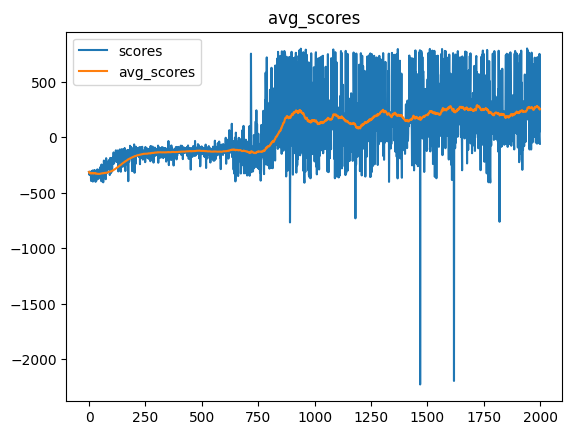

In [12]:
utils.plotting(scores=scores['scores'], avg_scores=scores['mean_scores'])

In [29]:
env = ga.make(env_id, render_mode = 'human', continuous=False, die_if_grass = die_if_grass, lap_complete_percent = 1, render_ray=True)
env.set_observation_transform(StateTfm())
# env.reset()
# env.set_reward_transform(RewardTfm())

agent.load(chkpt_dir, "best")
agent.play(env, stop_if_truncated=False)

744.9999999999985

In [15]:
scores = agent.fit(env, 1000, 1000, False, False, chkpt_dir, tqdm)

TypeError: 'EnvWithTransform' object cannot be interpreted as an integer

In [8]:
obs = env.reset()[0]

In [9]:
import matplotlib.pyplot as plt

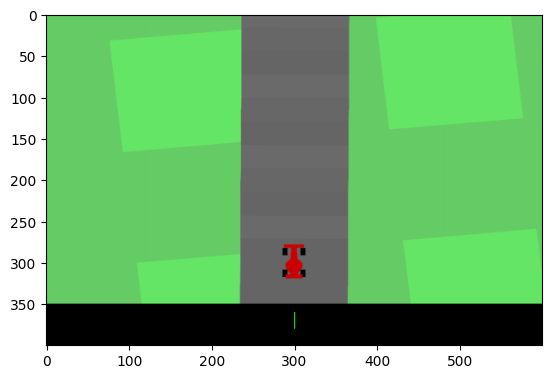

In [11]:
plt.imshow(env.render())
plt.savefig("test.png")